# Result Analysis for Deephyper Graph Neural Network
### Author: Shengli Jiang (sjiang87@wisc.edu)

### Datasets: QM7, QM8, QM9, ESOL, FreeSolv, Lipophilicity

In [1]:
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

import pandas as pd

from analysis_utils import load_json, to_sec, three_random_split, three_random_mean_std, create_csv

sns.set()
sns.set_context("talk", font_scale=1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rcParams["scatter.marker"] = 'o'
matplotlib.rcParams["lines.markersize"] = 5

### 1 Generate reward vs time figure

In [2]:
def plot_reward_vs_time(data, PLOT_DIR, ylim=None, time=True):
    start_infos = data['start_infos'][0]
    try:
        start_time = to_sec(data['workload']['times'][0])
    except:
        start_time = to_sec(start_infos['timestamp'])
    times = [to_sec(ts)-start_time for ts in data['timestamps']]
    x = times
    y = data['raw_rewards']
    plt.figure(figsize=(8.5, 6))
    if time:
        plt.plot(x, y, 'o', markersize=3)
        plt.xlabel('Time (sec)')
    else:
        plt.plot(y, 'o', markersize=3)
        plt.xlabel('Iterations')
    plt.ylabel('Reward (-MAE)')
    
    plt.xlim(left=0)
    if ylim is not None:
        plt.ylim(ylim)
    plt.locator_params(axis='y', nbins=6)
    plt.savefig(PLOT_DIR+'reward.png', dpi=300)

### 2.3 Three random split data parity plot

In [3]:
def three_random_parity_plot(DATA_DIR, PLOT_DIR, multi_class=False, limits=None):
    _, _, _, _, y_true_raw, y_pred_raw = three_random_split(DATA_DIR, multi_class=multi_class)
    if not multi_class:
        y_true = y_true_raw.ravel()
        y_pred = y_pred_raw.ravel()
        plt.figure(figsize=(8,6))
        min_value = np.min([y_true.min(), y_pred.min()])
        max_value = np.max([y_true.max(), y_pred.max()])
        dist = max_value - min_value
        min_value -= 0.03*dist
        max_value += 0.03*dist
        if limits is not None:
            min_value, max_value = limits
        plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
        plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
        plt.xlim(min_value, max_value)
        plt.ylim(min_value, max_value)
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.axis("square")
        plt.locator_params(axis='x', nbins=5)
        plt.locator_params(axis='y', nbins=5)
        plt.savefig(PLOT_DIR + "parity_plot.png")
    else:
        for c in range(y_true_raw.shape[-1]):
            y_true = y_true_raw[..., c].ravel()
            y_pred = y_pred_raw[..., c].ravel()
            plt.figure(figsize=(8,6))
            min_value = np.min([y_true.min(), y_pred.min()])
            max_value = np.max([y_true.max(), y_pred.max()])
            dist = max_value - min_value
            min_value -= 0.03*dist
            max_value += 0.03*dist
            if limits is not None:
                min_value, max_value = limits
            plt.plot(np.linspace(min_value, max_value, 100), np.linspace(min_value, max_value, 100), 'k--', alpha=0.5)
            plt.scatter(y_true.ravel(), y_pred.ravel(), s=5, alpha=0.9)
            plt.xlim(min_value, max_value)
            plt.ylim(min_value, max_value)
            plt.xlabel("True")
            plt.ylabel("Predicted")
            plt.axis("square")
            plt.locator_params(axis='x', nbins=5)
            plt.locator_params(axis='y', nbins=5)
            plt.savefig(PLOT_DIR + f"parity_plot_{c}.png")

### 3.1 CSV file to feature importance

In [4]:
def feature_importance(DATA_DIR, PLOT_DIR):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    X,y = df_new.values[:,0:-1], df_new.values[:,-1]
    X_train = X
    y_train = y
    rf = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=10)
    rf.fit(X_train, y_train)  
    y_pred = rf.predict(X_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-20:] 
    features = df_new.columns 
    plt.figure(figsize=(12,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(PLOT_DIR + 'feature_importance.png')
    return X, y, features, rf
#     print(df.values[y.argsort()[-10:][::-1],:])

### 4.1 MoleculeNet vs Deephyeper

In [5]:
def mol_vs_deep(DATA_DIR, PLOT_DIR, mol_m, mol_s, metric='MAE'):
    m, s = three_random_mean_std(DATA_DIR=DATA_DIR)
    labels = ["Train", "Valid", "Test"]
    if metric is 'MAE':
        m = m[:3]
        s = s[:3]
    if metric is 'MSE':
        m = m[3:6]
        s = s[3:6]
    plt.figure()
    plt.barh([0.25,-1.75,-3.75], m, color="maroon", align='center', height=0.5, label="Deephyper", xerr=s, capsize=5)
    plt.barh([-0.25,-2.25,-4.25], mol_m, color="gray", align='center', height=0.5, label="MoleculeNet", xerr=mol_s, capsize=5)
    plt.yticks([0,-2,-4], labels)
    plt.xlabel(f"{metric}")
    plt.legend(loc=1)
    plt.savefig(PLOT_DIR + f"{metric}_compare.png", dpi=300)

# QM7

In [24]:
QM7_PLOT_DIR = r"/mnt/d/plots/anl/qm7/"
QM7_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm7/run_0721/"
QM7_data = load_json(QM7_DATA_DIR + 'data_2020-07-24_13.json')

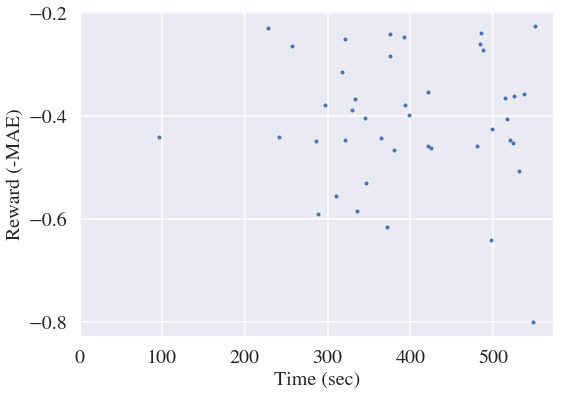

In [25]:
plot_reward_vs_time(QM7_data, QM7_PLOT_DIR)

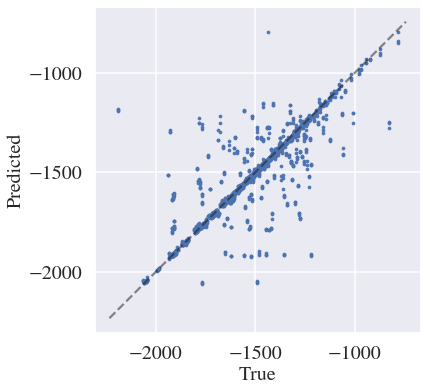

In [146]:
three_random_parity_plot(QM7_DATA_DIR, QM7_PLOT_DIR)

[32 1 'gcn' 2 'max' 'mlp' 'relu' 'connect' 32 2 'const' 4 'mean' 'gru'
 'tanh' 'skip' 'connect' 32 2 'const' 1 'sum' 'gru' 'elu' 'connect' 'skip'
 'connect' 'GlobalSumPool-2' -0.18447165191173556]


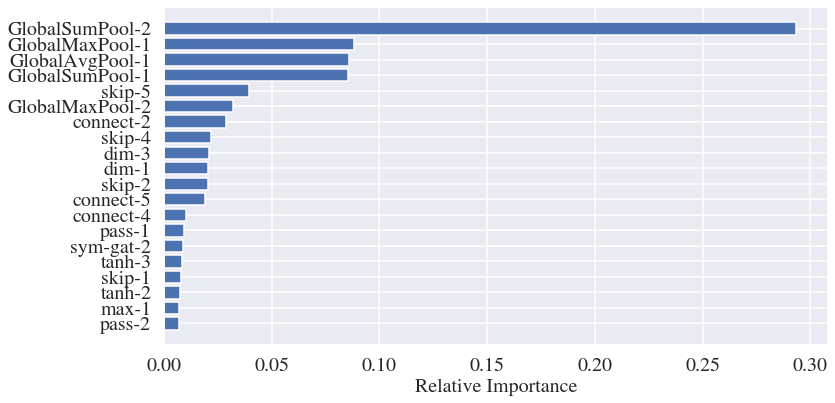

In [178]:
create_csv(QM7_DATA_DIR, QM7_data)
feature_importance(QM7_DATA_DIR, QM7_PLOT_DIR)

       MAE               MSE                    R2
-----  ----------------  ---------------------  ---------------
Train  39.6657+/-0.9336  11737.5352+/-88.8649   0.7609+/-0.0018
Valid  35.4343+/-0.4272  9454.5605+/-160.2698   0.8070+/-0.0033
Test   45.1978+/-1.0501  13369.0819+/-236.9001  0.7261+/-0.0049


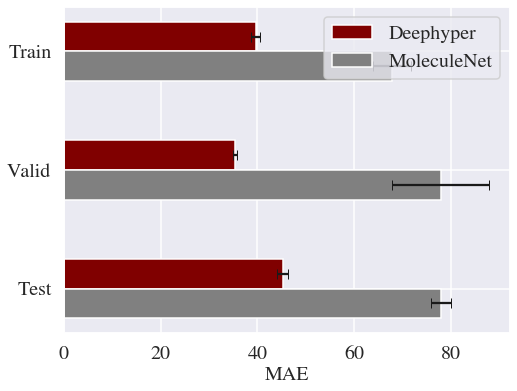

In [170]:
mol_vs_deep(QM7_DATA_DIR, QM7_PLOT_DIR, [67.8, 77.9, 77.9], [4.0, 10.0, 2.1], metric='MAE')

# QM8

In [8]:
QM8_PLOT_DIR = r"/mnt/d/plots/anl/qm8/"
QM8_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm8/run_0721/"
QM8_data = load_json(QM8_DATA_DIR + 'data_2020-07-24_13.json')

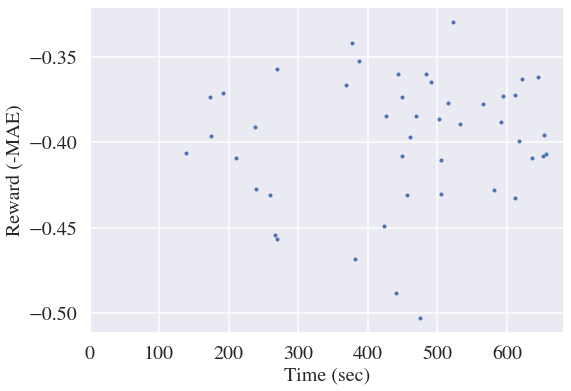

In [9]:
plot_reward_vs_time(QM8_data, QM8_PLOT_DIR)

In [89]:
three_random_mean_std(QM8_DATA_DIR)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0117+/-0.0000  0.0008+/-0.0000  0.9390+/-0.0003
Valid  0.0122+/-0.0000  0.0008+/-0.0000  0.9351+/-0.0012
Test   0.0124+/-0.0000  0.0009+/-0.0000  0.9320+/-0.0001


In [104]:
three_random_mean_std(QM8_DATA_DIR, multi_class=True)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0061+/-0.0001  0.0001+/-0.0000  0.9587+/-0.0014
Valid  0.0065+/-0.0001  0.0001+/-0.0000  0.9482+/-0.0029
Test   0.0063+/-0.0000  0.0001+/-0.0000  0.9589+/-0.0004
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0080+/-0.0001  0.0001+/-0.0000  0.8915+/-0.0022
Valid  0.0082+/-0.0000  0.0001+/-0.0000  0.8814+/-0.0036
Test   0.0082+/-0.0002  0.0001+/-0.0000  0.8854+/-0.0071
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0123+/-0.0001  0.0011+/-0.0000  0.6182+/-0.0093
Valid  0.0129+/-0.0002  0.0012+/-0.0000  0.6274+/-0.0090
Test   0.0130+/-0.0001  0.0012+/-0.0000  0.5407+/-0.0131
       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0286+/-0.0000  0.0032+/-0.0000  0.4135+/-0.0068
Valid  0.0291+/-0.0001  0.

[32 1 'gcn' 2 'sum' 'gru' 'tanh' 'connect' 16 2 'gat' 2 'mean' 'mlp' 'elu'
 'connect' 'skip' 32 3 'sym-gat' 6 'sum' 'mlp' 'tanh' 'connect' 'skip'
 'connect' 'GlobalMaxPool-2' -0.34357380867004395]


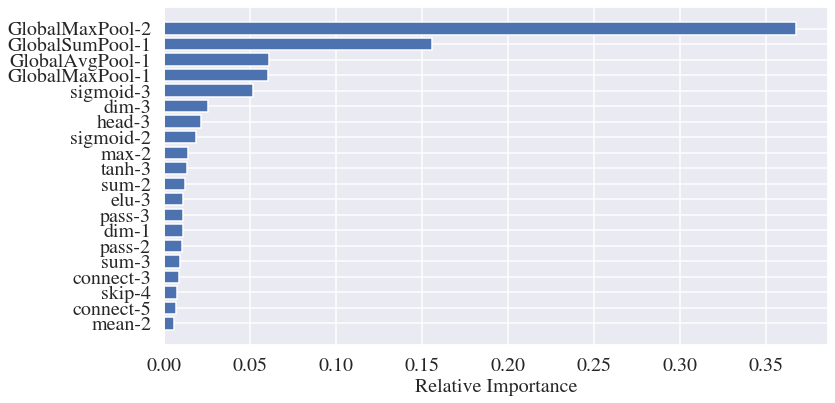

In [180]:
create_csv(QM8_DATA_DIR, QM8_data)
feature_importance(QM8_DATA_DIR, QM8_PLOT_DIR)

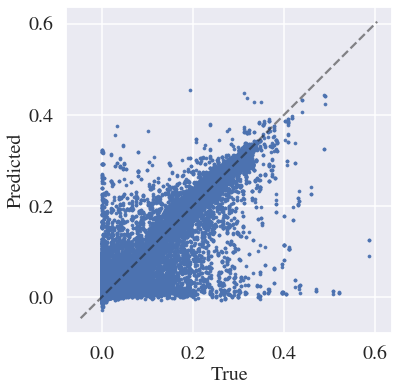

In [153]:
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR)

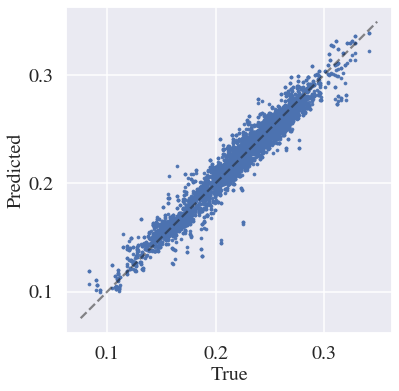

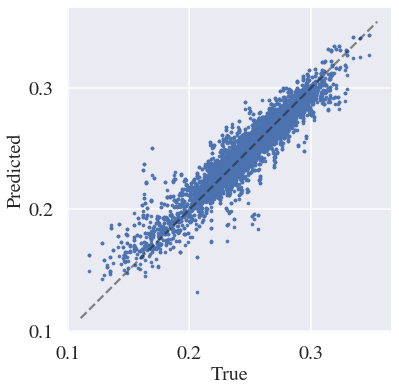

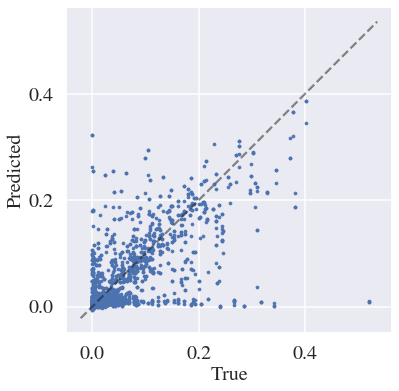

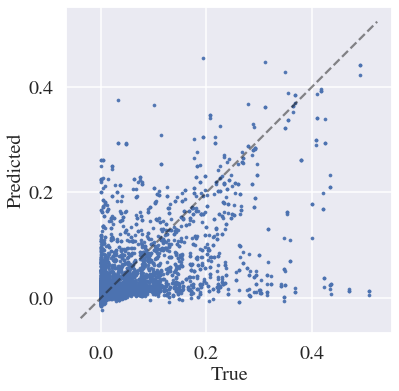

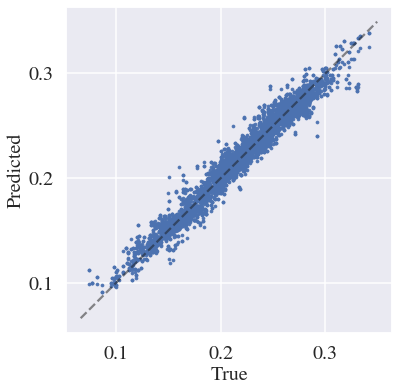

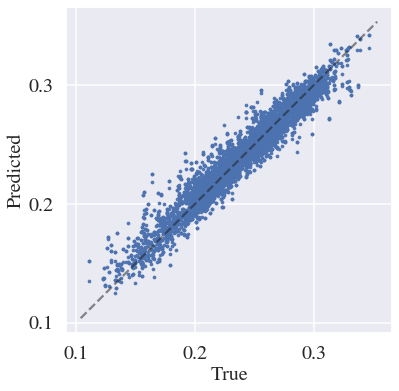

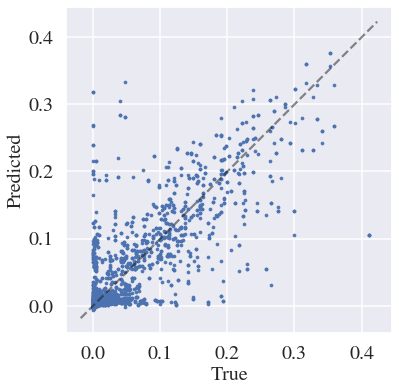

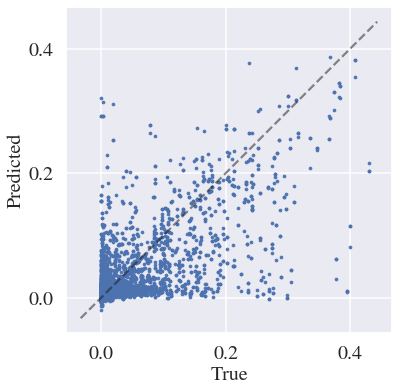

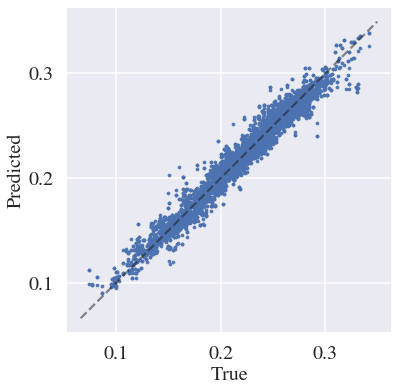

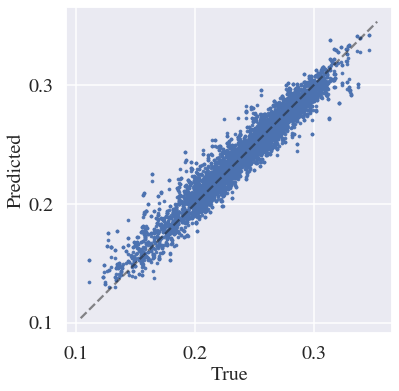

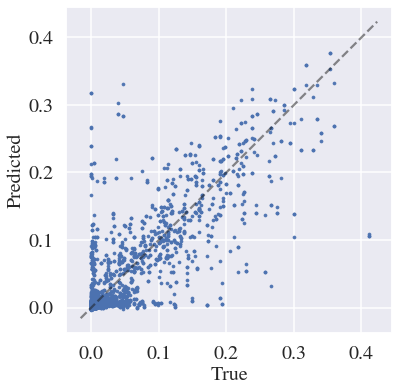

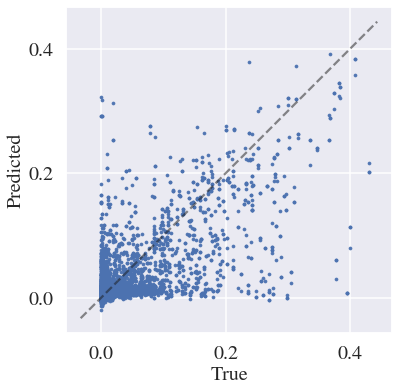

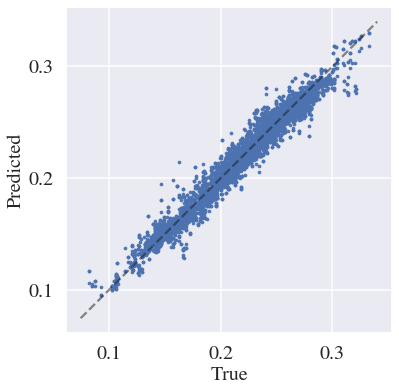

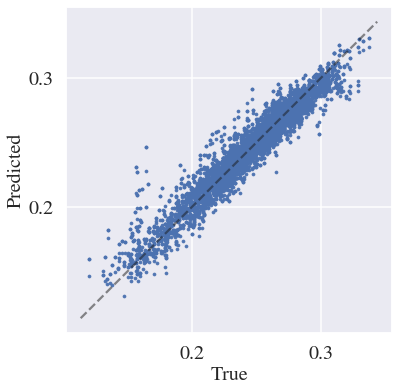

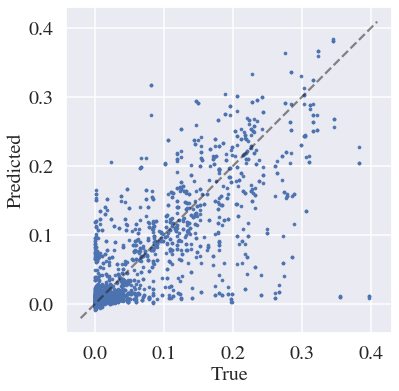

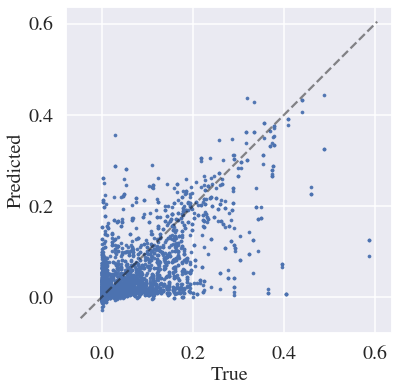

In [148]:
three_random_parity_plot(QM8_DATA_DIR, QM8_PLOT_DIR, multi_class=True)

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.0117+/-0.0000  0.0008+/-0.0000  0.9390+/-0.0003
Valid  0.0122+/-0.0000  0.0008+/-0.0000  0.9351+/-0.0012
Test   0.0124+/-0.0000  0.0009+/-0.0000  0.9320+/-0.0001


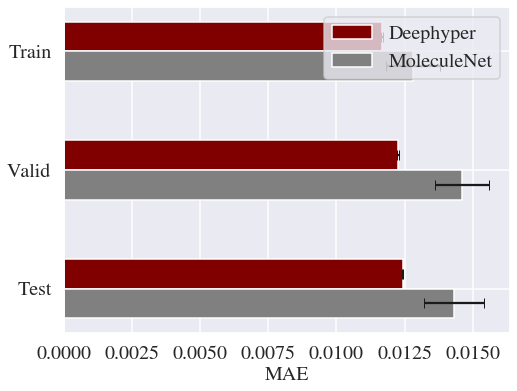

In [179]:
mol_vs_deep(QM8_DATA_DIR, QM8_PLOT_DIR, [0.0128, 0.0146, 0.0143], [0.001, 0.001, 0.0011], metric='MAE')

### QM9

In [10]:
QM9_PLOT_DIR = r"/mnt/d/plots/anl/qm9/"
QM9_DATA_DIR = r"/mnt/d/machinelearning2/ANL/qm9/run_0721/"
QM9_data = load_json(QM9_DATA_DIR + 'data_2020-07-24_04.json')

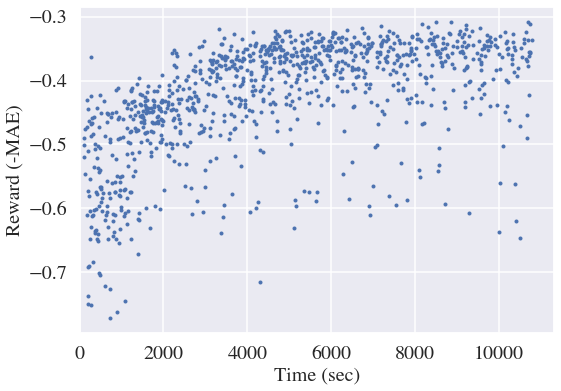

In [11]:
plot_reward_vs_time(QM9_data, QM9_PLOT_DIR)

# ESOL

In [6]:
ESOL_PLOT_DIR = r"/mnt/d/plots/anl/ESOL/"
ESOL_DATA_DIR = r"/mnt/d/machinelearning2/ANL/ESOL/run_0721/"
ESOL_data = load_json(ESOL_DATA_DIR + 'data_2020-07-24_13.json')

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.2865+/-0.0236  0.1403+/-0.0256  0.9680+/-0.0059
Valid  0.4673+/-0.0212  0.3945+/-0.0064  0.9153+/-0.0014
Test   0.4015+/-0.0134  0.2867+/-0.0064  0.9310+/-0.0015


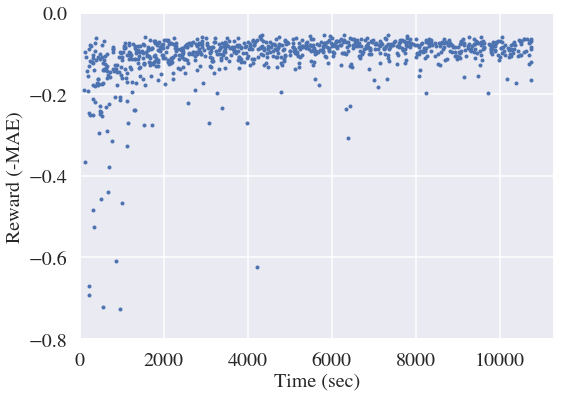

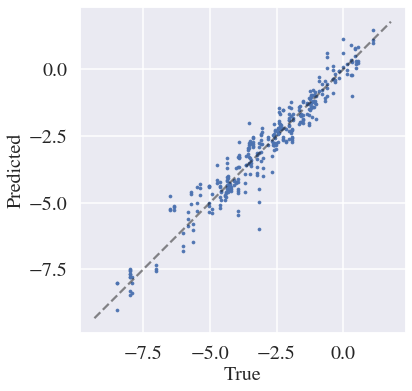

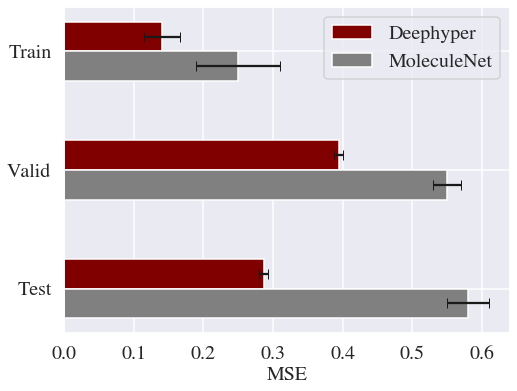

In [7]:
plot_reward_vs_time(ESOL_data, ESOL_PLOT_DIR, ylim=[-0.8, 0])
three_random_parity_plot(ESOL_DATA_DIR, ESOL_PLOT_DIR)
mol_vs_deep(ESOL_DATA_DIR, ESOL_PLOT_DIR, [0.25, 0.55, 0.58], [0.06, 0.02, 0.03], metric='MSE')

## FreeSolv

In [8]:
FreeSolv_PLOT_DIR = r"/mnt/d/plots/anl/FreeSolv/"
FreeSolv_DATA_DIR = r"/mnt/d/machinelearning2/ANL/FreeSolv/run_0721_extra/"
FreeSolv_data = load_json(FreeSolv_DATA_DIR + 'data_2020-07-24_13.json')

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.4371+/-0.1182  0.4434+/-0.2670  0.9696+/-0.0183
Valid  0.5535+/-0.0081  0.6791+/-0.0263  0.9609+/-0.0015
Test   0.6871+/-0.0485  1.4828+/-0.0079  0.8883+/-0.0006


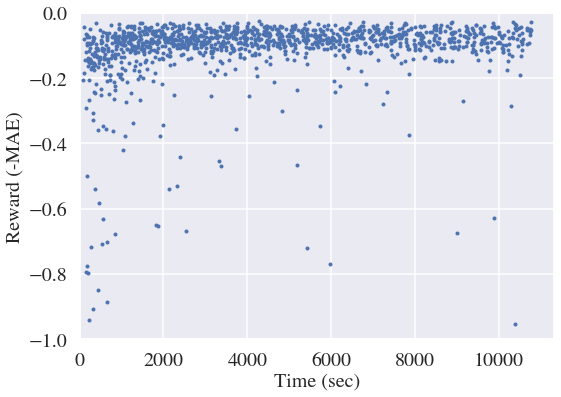

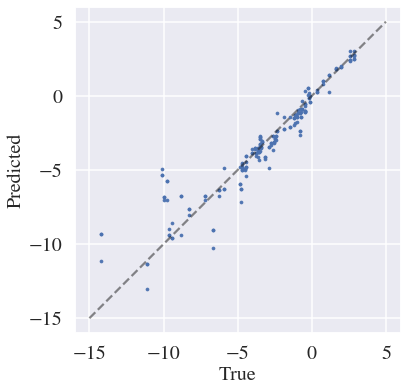

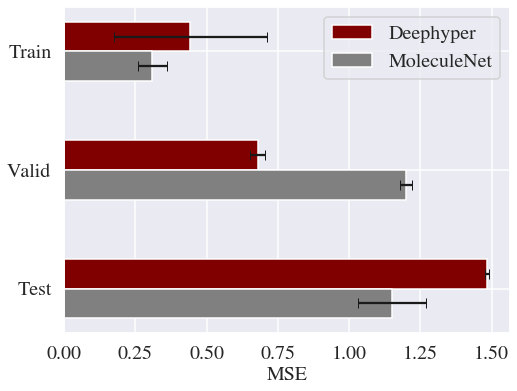

In [9]:
plot_reward_vs_time(FreeSolv_data, FreeSolv_PLOT_DIR, ylim=[-1.0, 0])
three_random_parity_plot(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, limits=(-15, 5))
mol_vs_deep(FreeSolv_DATA_DIR, FreeSolv_PLOT_DIR, [0.31, 1.20, 1.15], [0.05, 0.02, 0.12], metric='MSE')

## Lipophilicity

In [10]:
LIPO_PLOT_DIR = r"/mnt/d/plots/anl/Lipo/"
LIPO_DATA_DIR = r"/mnt/d/machinelearning2/ANL/Lipo/run_0721/"
LIPO_data = load_json(LIPO_DATA_DIR + 'data_2020-07-21_14.json')

       MAE              MSE              R2
-----  ---------------  ---------------  ---------------
Train  0.3871+/-0.0377  0.2572+/-0.0441  0.8185+/-0.0311
Valid  0.4550+/-0.0148  0.3656+/-0.0183  0.7620+/-0.0119
Test   0.4678+/-0.0371  0.3598+/-0.0514  0.7728+/-0.0324


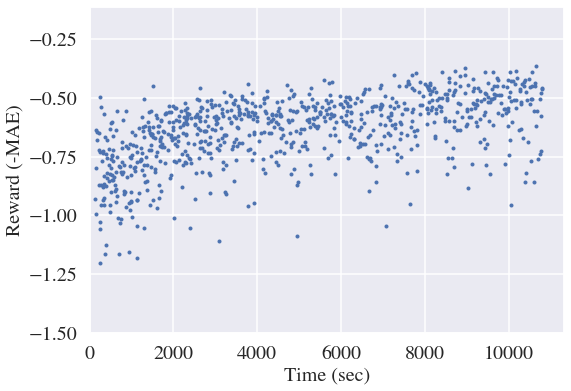

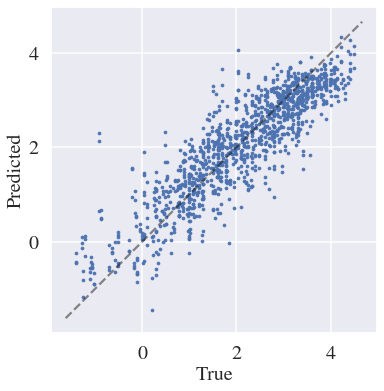

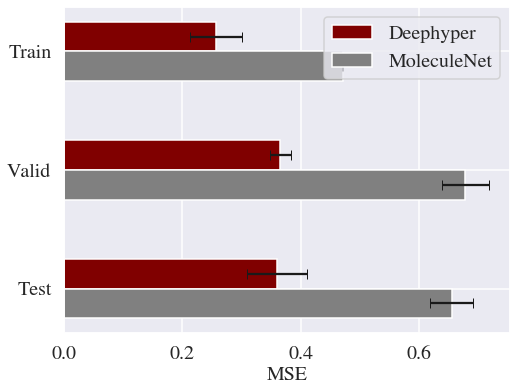

In [11]:
plot_reward_vs_time(LIPO_data, LIPO_PLOT_DIR, ylim=[-1.5, None])
three_random_parity_plot(LIPO_DATA_DIR, LIPO_PLOT_DIR)
mol_vs_deep(LIPO_DATA_DIR, LIPO_PLOT_DIR, [0.471, 0.678, 0.655], [0.001, 0.04, 0.036], metric='MSE')

In [72]:
def feature_importance(DATA_DIR, PLOT_DIR):
    train_data = pd.read_csv(DATA_DIR + 'nas_result.csv', header=None)
    df = train_data
    df_new = pd.DataFrame()
    for i in range(df.shape[1]):
        if (df.dtypes[i] == 'object'):
            vals = pd.get_dummies(df.iloc[:,i])
        else:
            vals = df.iloc[:,i]
        df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
    X,y = df_new.values[:,0:-1], df_new.values[:,-1]
    X_train = X
    y_train = y
    rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 0)
    rf.fit(X_train, y_train)  
    y_pred = rf.predict(X_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[-20:] 
    features = df_new.columns 
    plt.figure(figsize=(12,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(PLOT_DIR + 'feature_importance.png')
    print(rf.score(X_train, y_train), rf.oob_score_)
    return X, y, features, rf
#     print(df.values[y.argsort()[-10:][::-1],:])

In [59]:
from rfpimp import permutation_importances
train_data = pd.read_csv(LIPO_DATA_DIR + 'nas_result.csv', header=None)
df = train_data
df_new = pd.DataFrame()
for i in range(df.shape[1]):
    if (df.dtypes[i] == 'object'):
        vals = pd.get_dummies(df.iloc[:,i])
    else:
        vals = df.iloc[:,i]
    df_new = pd.concat([df_new.reset_index(drop=True), vals.reset_index(drop=True)], axis=1)
X,y = df_new.values[:,0:-1], df_new.values[:,-1]
X_train = X
y_train = y
features = df_new.columns 

In [ ]:
perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

0.853190702662282 0.11228867207633597


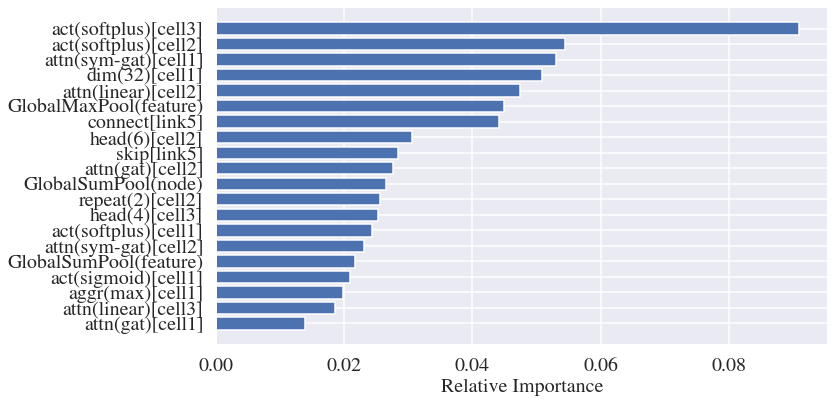

In [73]:
X, y, f, rf = feature_importance(LIPO_DATA_DIR, LIPO_PLOT_DIR)

In [62]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 0):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    X_train = pd.DataFrame(X_train)
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
#     importances_df = imp_df(X_train.columns, importances)
    return importances

In [63]:
importances = drop_col_feat_imp(rf, X, y)

Text(0.5, 0, 'Relative Importance')

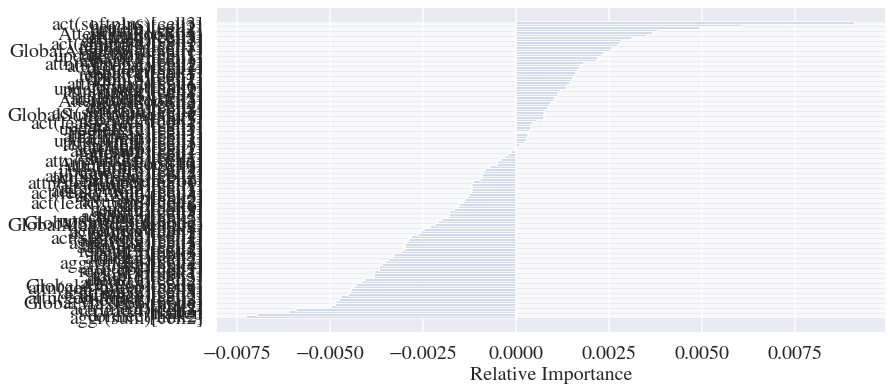

In [69]:
indices = np.argsort(importances)
features = f
plt.figure(figsize=(12,6))
plt.barh(range(len(indices)), [importances[i] for i in indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [75]:
a = np.array([features[i] for i in indices])
np.where(a=='attn(const)[cell3]')

(array([61]),)

In [16]:
with open(FreeSolv_DATA_DIR + 'best_archs.json', 'r') as f:
    data = json.load(f)

In [21]:
from FreeSolv.FreeSolv.problem import Problem
import tensorflow.keras.backend as K

In [23]:
for i in range(10):
    ops = data['arch_seq'][i]
    search_space = Problem.space['create_search_space']['func']()
    search_space.set_ops(ops)
    model = search_space.create_model()
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    print(f'{i}: {trainable_count}')

0: 34033
1: 124361
2: 225409
3: 226721
4: 229153
5: 125473
6: 20645
7: 20745
8: 30529
9: 122738


In [76]:
a = [12582,1,10199,1,1,7828,1,0,1,9]

In [77]:
state_dims = ['dim(4)', 'dim(8)', 'dim(16)', 'dim(32)']
Ts = ['repeat(1)', 'repeat(2)', 'repeat(3)', 'repeat(4)']
attn_methods = ['attn(const)', 'attn(gcn)', 'attn(gat)', 'attn(sym-gat)', 'attn(linear)', 'attn(gen-linear)', 'attn(cos)']
attn_heads = ['head(1)', 'head(2)', 'head(4)', 'head(6)']
aggr_methods = ['aggr(max)', 'aggr(mean)', 'aggr(sum)']
update_methods = ['update(gru)', 'update(mlp)']
activations = ['act(sigmoid)', 'act(tanh)', 'act(relu)', 'act(linear)', 'act(elu)', 'act(softplus)', 'act(leaky_relu)', 'act(relu6)']

out = []
for state_dim in state_dims:
    for T in Ts:
        for attn_method in attn_methods:
            for attn_head in attn_heads:
                for aggr_method in aggr_methods:
                    for update_method in update_methods:
                        for activation in activations:
                            out.append([state_dim, T, attn_method, attn_head, aggr_method, update_method, activation])

out_pool = []
for functions in ['GlobalSumPool', 'GlobalMaxPool', 'GlobalAvgPool']:
    for axis in ['(feature)', '(node)']:  # Pool in terms of nodes or features
        out_pool.append(functions+axis)
out_pool.append('flatten')
for state_dim in [16, 32, 64]:
    out_pool.append(f'AttentionPool({state_dim})')
out_pool.append('AttentionSumPool')

out_connect = ['skip', 'connect']

def get_gat(index):
    return out[index]
def get_pool(index):
    return out_pool[index]
def get_connect(index):
    return out_connect[index]


temp = a
b0 = [get_gat(temp[0])[i]+'[cell1]' for i in range(len(get_gat(temp[0])))]
b1 = [get_connect(temp[1])+'[link1]']
b2 = [get_gat(temp[2])[i]+'[cell2]' for i in range(len(get_gat(temp[2])))]
b3 = [get_connect(temp[3])+'[link2]']
b4 = [get_connect(temp[4])+'[link3]']
b5 = [get_gat(temp[5])[i]+'[cell3]' for i in range(len(get_gat(temp[5])))]
b6 = [get_connect(temp[6])+'[link4]']
b7 = [get_connect(temp[7])+'[link5]']
b8 = [get_connect(temp[8])+'[link6]']
b9 = [get_pool(temp[9])]
bout = b0+b1+b2+b3+b4+b5+b6+b7+b8+b9
bout = np.array(bout, dtype=object)
bout

array(['dim(16)[cell1]', 'repeat(2)[cell1]', 'attn(gat)[cell1]',
       'head(4)[cell1]', 'aggr(max)[cell1]', 'update(gru)[cell1]',
       'act(leaky_relu)[cell1]', 'connect[link1]', 'dim(8)[cell2]',
       'repeat(4)[cell2]', 'attn(linear)[cell2]', 'head(1)[cell2]',
       'aggr(mean)[cell2]', 'update(gru)[cell2]', 'act(relu6)[cell2]',
       'connect[link2]', 'connect[link3]', 'dim(8)[cell3]',
       'repeat(2)[cell3]', 'attn(gen-linear)[cell3]', 'head(6)[cell3]',
       'aggr(max)[cell3]', 'update(gru)[cell3]', 'act(elu)[cell3]',
       'connect[link4]', 'skip[link5]', 'connect[link6]',
       'AttentionPool(64)'], dtype=object)